In [1]:
# a bit of setup
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import scipy.stats as stats
from pydub import AudioSegment
% matplotlib inline

In [2]:
def build_bigram_freq_matrix(input_arr, alphabet_size):
    """
    Builds a matrix that represents the transitional
    probabilities between letters in input_file.
    
    bigram_freq_matrix[0][1] is the probability of
    transitioning from the 0th letter of the alphabet
    to the 1st letter of the alphabet, where letters
    are zero-indexed. ' ' (space) is denoted as the
    26th letter of the alphabet.
    """
    counts = np.ones([alphabet_size, alphabet_size])
    
    for i in range(len(input_arr) - 2):
        first_char = input_arr[i]
        second_char = input_arr[i+1]
        counts[first_char][second_char] += 1
        
    return (counts.T / np.sum(counts, axis=1)).T
        

In [30]:
note_map = {
    "C": 0,
    "D": 1,
    "E": 2,
    "F": 3,
    "G": 4,
    "A": 5,
    "B": 6,
    "--": 7
}

index_map = {
    0: "C",
    1: "D",
    2: "E",
    3: "F",
    4: "G",
    5: "A",
    6: "B",
    7: "--"
}

In [18]:
song_str = "E E F G G F E D C C D E E E E " +\
            "E E F G G F E D C C D E D C C " +\
            "D D E C D E E C D E E D C D -- " +\
            "E E F G G F E D C C D E D C C"
song_arr = [note_map[s] for s in song_str.split(" ")]

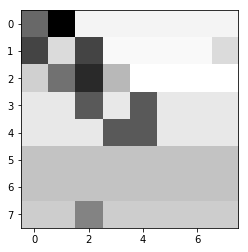

In [32]:
M = build_bigram_freq_matrix(song_arr, len(note_map))
plt.imshow(M, cmap='binary', interpolation='none')

In [20]:
cipher = np.random.permutation(range(len(note_map)))
encrypted = [cipher[i] for i in song_arr]

In [21]:
def decode(string, ordering):
    """
    Decodes a string according to the given
    ordering.
    
    ordering: a list representing the cipher.
        For example, if in our cipher, 'a'
        should be replaced with 'c', then 
        ordering[0] should equal 2.
    """
    output_str = ""
    for i in string:
        output_str += index_map[ordering[i]] + " "
    return output_str[:-1]

In [22]:
alph_size = len(note_map)

def starting_state():
    """
    Start with a random permutation.
    """
    starting_ordering = list(range(0, alph_size))
    np.random.shuffle(starting_ordering)
    return starting_ordering

def sample_candidate(sample):
    """
    To search for new ciphers, randomly
    swap two letters in the previous cipher.
    """
    to_swap = np.random.choice(alph_size, 2)
    new_sample = sample[:]
    new_sample[to_swap[0]], new_sample[to_swap[1]] = sample[to_swap[1]], sample[to_swap[0]]
    return new_sample

def make_acceptance_scorer(decode_string, transition_matrix):
    """
    Calculate the acceptance probability, which is the
    probability of observing the message translated by
    the proposed cipher devided by the probability of
    obseving the message translated by the current
    cipher.
    """
    def scorer(candidate, sample):
        nonlocal transition_matrix
        nonlocal decode_string
        candidate_log_likeihood = 0
        sample_log_likeihood = 0
        for i in range(len(decode_string) - 1):
            first_char = decode_string[i]
            second_char = decode_string[i + 1]
            
            c_first, c_second = candidate[first_char], candidate[second_char]
            candidate_log_likeihood += np.log(transition_matrix[c_first][c_second])

            s_first, s_second = sample[first_char], sample[second_char]
            sample_log_likeihood += np.log(transition_matrix[s_first][s_second])
        return np.exp(candidate_log_likeihood - sample_log_likeihood)
    return scorer

scorer = make_acceptance_scorer(encrypted, M)

In [23]:
def metropolis_hastings(proposal_func, init_func, acceptance_score, num_iters, step=30):
    """
    Runs the metropolis-hastings algorithm for
    num_iters iterations, using proposal_func
    to generate samples and scorer to assign
    probability scores to samples.
      
    proposal_func -- function that proposes
        candidate state; takes in current state as
        argument and returns candidate state
    init_func -- function that proposes starting
        state; takes no arguments and returns a
        sample state
    acceptance_score -- function that calculates the acceptance
        probability; takes in two state samples
        (candidate first, then sample) and returns
        acceptance probability
    
    Returns a sequence of every step-th sample. You 
    should only sample on upon acceptance of a new
    proposal. Do not keep sampling the current state.
    
    Note the total number of samples will NOT be
    equal to num_iters. num_iters is the total number
    of proposals we generate.
    """
    samples = []
    sample = init_func()
    for i in range(num_iters):
        candidate = proposal_func(sample)
        acceptance_ratio = min(1, acceptance_score(candidate,sample))
        if np.random.uniform() < acceptance_ratio:
            sample = candidate
            samples.append(sample)
    return samples[::step]

In [24]:
samples = metropolis_hastings(sample_candidate, starting_state, scorer, 10000)

In [25]:
combined = [" ".join([str(x) for x in s]) for s in samples]
best_combined = max(set(combined),key=combined.count)
your_best_cipher = [int(x) for x in best_combined.split()]
decrypted = decode(encrypted,your_best_cipher)

In [26]:
a = AudioSegment.from_file("a.mp3")
b = AudioSegment.from_file("b.mp3")
c = AudioSegment.from_file("c.mp3")
d = AudioSegment.from_file("d.mp3")
e = AudioSegment.from_file("e.mp3")
f = AudioSegment.from_file("f.mp3")
g = AudioSegment.from_file("g.mp3")
rest = AudioSegment.from_file("rest.mp3")

audio_dict = {
    "A": a,
    "B": b,
    "C": c,
    "D": d,
    "E": e,
    "F": f,
    "G": g,
    "--": rest
}

In [27]:
def play(notes):
    to_play = []
    for note in notes.split(" "):
        to_play.append(audio_dict[note])
    return sum(to_play)

In [28]:
play(song_str)

In [29]:
play(decrypted)